# Imports and Reading Data Files

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import style
from scipy import stats 
import seaborn as sns
# import torch

from scipy.stats import multivariate_normal as mvn


%matplotlib inline
style.use('ggplot')

# df = pd.read_csv("raw_scania_train_data.csv", delimiter=',')

# Columns with 'na' values are treated as nan.
df = pd.read_csv("raw_scania_train_data.csv", delimiter=',', na_values = 'na')
test_df = pd.read_csv("raw_scania_test_data.csv", delimiter=',', na_values = 'na')

In [2]:
import imblearn
print(imblearn.__version__)

0.7.0


# Classification and Regression Classes

In [3]:
class GaussBernoulli():
    
    def fit(self, X, y, DistStr, epsilon = 1e-2):
        N, D = X.shape
        
        self.likelihoods = dict()
        self.priors = dict()
        
        # sometimes y is float or boolean, etc. So we make sure they are converted into ints
        self.K = set(y.astype(int))

        if DistStr=="Gauss":
            for k in self.K:
                X_k = X[y == k,:]
                N_k, D = X_k.shape
                mu_k=X_k.mean(axis=0)
                
                self.likelihoods[k] = {"mean":X_k.mean(axis=0), "cov":(1/(N_k-1))*np.matmul((X_k-mu_k).T,X_k-mu_k)+ epsilon*np.identity(D)}
                self.priors[k] = len(X_k)/len(X)
            return

        if DistStr=="Bernoulli":
            for k in self.K:
                X_k = X[y==k, :]
                N_k, D = X_k.shape
                p = (sum(X_k)+1) / (N_k + 2)
                # p is a list if X is a matrix.
                self.likelihoods[k] = {'mean' : p, 'cov' : p * (1-p) + epsilon}
                self.priors[k] = N_k/N
            
    def predict(self, X,DistStr):
        N, D = X.shape
        P_hat = np.zeros((N,len(self.K)))

        
        if DistStr=="Gauss":
            for k, l in self.likelihoods.items():
                P_hat[:,k] = mvn.logpdf(X, l["mean"], l["cov"]) + np.log(self.priors[k])

        if DistStr=="Bernoulli":
            for k, l in self.likelihoods.items():
                # matmul is matrix multiplication
                # Using bernoulli function/formula. Trick is to get the matrices/vectors to go from m*n to a 1*1 number for each k value.
                P_hat[:,k] = np.log(self.priors[k]) + np.matmul(X, np.log(l["mean"])) + np.matmul((1-X), np.log(l["cov"]))

        return P_hat.argmax(axis = 1)

In [4]:
class KNNClassifier():
    
    def fit(self, X, y):
        self.X = X
        self.y = y
    
    def predict(self, X, K, epsilon = 1e-3):
        N = len(X)
        y_hat = np.zeros(N)
        
        for i in range(N):
            dist2 = np.sum((self.X-X[i])**2, axis=1)
            idxt = np.argsort(dist2)[:K]   # We just need the top K values.
            gamma_k = 1/(np.sqrt(dist2[idxt]) + epsilon)
#             y_hat[i] = np.bincount(self.y[idxt], weights=gamma_k.argmax())    # Finds the best match for classification.
            y_hat[i] = np.bincount(self.y[idxt].reshape(15, ).astype(int), weights=gamma_k).argmax()    # Finds the best match for classification.
        return y_hat

In [5]:
class LinearRegression():
    def fit(self, X, y):
        # @ is element-wise multiplication
        self.w = np.linalg.solve(X.T@X, X.T@y)
        
    def predict(self, X):
        return np.matmul(X, self.w)

In [6]:
class KNNRegressor():
    
    def fit(self, X, y):
        self.X = X
        self.y = y
    
    def predict(self, X, K, epsilon=1e-3):
        N=len(X)
        y_hat=np.zeros(N)
        
        for i in range(N):
            dist2 = np.sum((self.X-X[i])**2, axis = 1)
            idxt = np.argsort(dist2)[:K]
            gamma_k = np.exp(-dist2[idxt])/np.exp(-dist2[idxt]).sum()
            y_hat[i] = gamma_k.dot(self.y[idxt])
            
        return y_hat

In [7]:
class MVLogisticRegression():
    def __init__(self, thresh = 0.5):
        self.thresh = thresh

    def fit(self, X, y, eta = 2e-1, epochs = 1e3, show_curve = False):
        epochs = int(epochs)
        N, D = X.shape

        K = len(np.unique(y))
        y_values = np.unique(y, return_index = False)
        Y = indices_to_one_hot(y, K).astype(int)

        self.W = np.random.randn(D, K)
        self.B = np.random.randn(1, K)

        J = np.zeros(int(epochs))

        # Gradiant Decent
        for epoch in range(epochs):
            P_hat = self.__forward__(X)
            J[epoch] = cross_entropy(Y, P_hat)
            # The value to the right of eta is the gradiant.
            self.W -= eta * (1/N) * X.T@(P_hat-Y)
            self.B -= eta * (1/N) * np.sum(P_hat - Y, axis = 0)

        if show_curve:
            plt.figure()
            plt.plot(J)
            plt.xlabel('epochs')
            plt.ylabel('$\mathcal{J}$')
            plt.title('Training Curve')
            plt.show()

    def __forward__(self, X):
#         print('Forward:', X.shape)
#         print('Forward:', (X@self.W + self.B).shape)
        return softmax(X@self.W + self.B)
#         return sigmoid(X@self.W + self.B)

    def predict(self, X):
#         print('predict:', X.shape)
        return np.argmax(self.__forward__(X), axis = 1)
#         return np.tanh(self.__forward__(X))


# Helper Functions

In [8]:
def findOutliers(df, col, show_message = False):
    new_df = df.filter([col], axis=1)
    new_df = new_df[new_df[col].notna()]
    new_df = new_df.astype(float)

    Q1 = np.percentile(new_df, 25, interpolation = 'midpoint')  
    Q2 = np.percentile(new_df, 50, interpolation = 'midpoint')  
    Q3 = np.percentile(new_df, 75, interpolation = 'midpoint')  
    IQR = stats.iqr(new_df, interpolation = 'midpoint') 

    if show_message:
        print('Q1 25 percentile of the given data is, ', Q1) 
        print('Q1 50 percentile of the given data is, ', Q2) 
        print('Q1 75 percentile of the given data is, ', Q3) 
        print(IQR)

    low_lim = Q1 - 1.5 * IQR 
    up_lim = Q3 + 1.5 * IQR 
    if show_message:
        print('low_limit is', low_lim) 
        print('up_limit is', up_lim)

    outlier =[] 
    for x in new_df[col]: 
        if ((x> up_lim) or (x<low_lim)): 
             outlier.append(x) 
    if show_message:
        print('Outlier in the dataset is', len(outlier)) 
    outlierPercent = round(100 * len(outlier)/len(new_df), 2)
    if show_message:
        print(f'Percentage of outlier in the dataset is {outlierPercent}') 
    return len(outlier), outlierPercent

def min_max_normalization(df):
    for col in df.columns:
        col_min = df[col].min()
        col_max = df[col].max()
        col_range = col_max - col_min
        if col_min == col_max:
            print('Column:', col, 'has only one value!')
        else:
            df[col] = (df[col] - col_min) / (col_max - col_min)
    return df

def aray_min_max_normalization(arr):
    for col in range(arr.shape[0]):
        col_min = arr[col].min()
        col_max = arr[col].max()
        col_range = col_max - col_min
        if col_min == col_max:
            print('Column:', col, 'has only one value!')
        else:
            arr[col] = (arr[col] - col_min) / (col_max - col_min)
    return arr


def numpy_fit_predict(X_train, y_train, X_test, y_test, gb):
#     gb.fit(X_train,y_train, 'Bernoulli')
#     y_hat = gb.predict(X_test, 'Bernoulli')
#     print(f"Bernoulli Accuracy: {accuracy(y_test, y_hat):0.2f}%.")
    
    gb.fit(X_train,y_train, 'Gauss')
    y_hat = gb.predict(X_test, 'Gauss')
    print(get_metrics(y_test, y_hat))

    return y_hat


def fit_predict(train_df, test_df, gb):
    train_data = train_df.to_numpy()
    test_data = test_df.to_numpy()

    X_train = train_data[:, 1:]
    X_test = test_data[:, 1:]
    y_train = train_data[:, 0]
    y_test = test_data[:, 0]

    print(train_df.shape)
    print(X_train.shape)
    print(y_train.shape)
    print(test_df.shape)
    print(X_test.shape)
    print(y_test.shape)
    
#     gb.fit(X_train,y_train, 'Bernoulli')
#     y_hat = gb.predict(X_test, 'Bernoulli')
#     print(f"Bernoulli Accuracy: {accuracy(y_test, y_hat):0.2f}%.")
    
    gb.fit(X_train,y_train, 'Gauss')
    y_hat = gb.predict(X_test, 'Gauss')
    print(get_metrics(y_test, y_hat))

    return y_test, y_hat
    
def get_metrics(y, y_hat):
    if len(y) != len(y_hat):
        print('Two inputs are of differnet length!')
        return null

    true_pos = 0
    false_pos = 0
    true_neg = 0
    false_neg = 0
    
    for i in range(len(y)):
        if y[i] == 1:
            if y_hat[i] == 1:
                true_pos += 1
            else:
                false_neg += 1
        else:
            if y_hat[i] == 1:
                false_pos += 1
            else:
                true_neg += 1
    print(f'true_pos= {true_pos}, false_neg= {false_neg}, false_pos= {false_pos}, true_neg= {true_neg}')
                
    # Accuracy
    counter = 0
    for i in range(len(y)):
        if y[i] == y_hat[i]:
            counter += 1
    accuracy = round(100 * counter / len(y), 2)
    
    # Precision
    precision = round(true_pos / (true_pos + false_pos), 4)
    
    # Sensitivity
    sensitivity = round(true_pos / (true_pos + false_neg), 4)
    
    # Specificity
    specifity = round(true_neg / (false_pos + true_neg), 4)
    
    # Recall
    recall = round(true_pos / (true_pos + false_neg), 4)
    
    # NPV
    npv = round(true_neg / (true_neg + false_neg), 4)
    
    # F1
    f1 = round(2 * precision * recall / (precision + recall), 4)

    return {'accuracy' : accuracy, 'precision' : precision, 'sensitivity' : sensitivity, 'specifity' : specifity, 'recall' : recall, 'npv' : npv, 'f1' : f1}

def find_inf_nan_onevalues(df):
    for col in df.columns:
        if np.isinf(df[col]).any():
            print('Column:', col, 'has inf values!')

        na_count = df[col].isna().sum()
        if na_count > 0:
            print('Column:', col, 'has', na_count, ' NaN values!')


        col_min = df[col].min()
        col_max = df[col].max()
        col_range = col_max - col_min
        if col_min == col_max:
            print('Column:', col, 'has only one value!')
    print('Done')
    
def over_sample(df, over_sample_rate):
    osdf = df.copy(deep=True)
    pos = osdf[osdf['output'] == 1]
    print(osdf.shape)
    print(pos.shape)
    newpos = pd.DataFrame(np.repeat(pos.values, over_sample_rate, axis=0))
    newpos.columns = pos.columns
    osdf = osdf.append(newpos)
    print(osdf.shape)
    return osdf

def remove_high_missing_columns(df, test_df, missing_val_ration):
    na_cols = df.isna().sum()
    top_na_cols = []

    missing_numbers_threshold = df.shape[0] * missing_val_ration
    print(missing_numbers_threshold)
    for col, missing_numbers in na_cols.items():
        if missing_numbers > missing_numbers_threshold:
            top_na_cols.append(col)
    df = df.drop(columns = top_na_cols, axis=1)
    print('Train data: ', df.shape)
    test_df = test_df.drop(columns = top_na_cols, axis=1)
    print('Test data: ', test_df.shape)
    [na_cols.pop(key) for key in top_na_cols]
    df.shape
    return df, test_df

def sigmoid(h):
#     print(h)
    return 1/(1 + np.exp(-h))

def softmax(h):
    return (np.exp(h.T)/np.sum(np.exp(h), axis = 1)).T


def cross_entropy(Y, p_hat):
    return -(1/len(Y)) * np.sum(np.sum(Y * np.log(p_hat), axis = 1), axis = 0)

# def accuracy(y, y_hat):
#   return np.mean(y == y_hat)

def indices_to_one_hot(data, nb_classes):
    targets = np.array(data).reshape(-1)
    return np.eye(nb_classes)[targets]

# Imputation by linear interpolation.
def lin_imputation(mydf):
    col_count = len(mydf.columns)
    row_count = mydf.shape[0]
    first_col = mydf['aa_000']
    for col in range(3, col_count):
        current_col_name = mydf.columns[col]
        current_col = mydf[['my_index', current_col_name]]
        current_col = current_col[current_col[current_col_name].notnull()]
        print('Imputing column[' + str(col) + ']: ' + current_col_name + 
              ', current_col size= ' + str(current_col.shape[0]))

        for i in range(1, current_col.shape[0]):
            if current_col.iloc[i, 0] != current_col.iloc[i - 1, 0] + 1:
                prev_index = current_col.iloc[i - 1, 0]
                next_index = current_col.iloc[i, 0]
                # Impute missing values.
                prev_row_1 = first_col.iloc[prev_index]
                next_row_1 = first_col.iloc[next_index]
                prev_row_col = mydf.iloc[prev_index, col]
                next_row_col = mydf.iloc[next_index, col]
                fixed_part = (next_row_col - prev_row_col) / (next_row_1 - prev_row_1)
                for j in range(prev_index + 1, next_index):
                    mydf.iat[j, col] = prev_row_col + ((first_col.iloc[j] - prev_row_1) * fixed_part)
    return mydf

# Exploring the data

In [9]:
df.describe(include = 'all')

,index,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,60000.000000,60000,6.000000e+04,13671.000000,5.666500e+04,4.513900e+04,57500.000000,57500.000000,5.932900e+04,5.932900e+04,...,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,57276.000000,57277.000000
unique,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,neg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,59000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,29999.500000,NaN,5.933650e+04,0.713189,3.560143e+08,1.906206e+05,6.819130,11.006817,2.216364e+02,9.757223e+02,...,4.454897e+05,2.111264e+05,4.457343e+05,3.939462e+05,3.330582e+05,3.462714e+05,1.387300e+05,8.388915e+03,0.090579,0.212756
std,17320.652413,NaN,1.454301e+05,3.478962,7.948749e+08,4.040441e+07,161.543373,209.792592,2.047846e+04,3.420053e+04,...,1.155540e+06,5.433188e+05,1.168314e+06,1.121044e+06,1.069160e+06,1.728056e+06,4.495100e+05,4.747043e+04,4.368855,8.830641
min,0.000000,NaN,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,14999.750000,NaN,8.340000e+02,0.000000,1.600000e+01,2.400000e+01,0.000000,0.000000,0.000000e+00,0.000000e+00,...,2.936000e+03,1.166000e+03,2.700000e+03,3.584000e+03,5.120000e+02,1.100000e+02,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,29999.500000,NaN,3.077600e+04,0.000000,1.520000e+02,1.260000e+02,0.000000,0.000000,0.000000e+00,0.000000e+00,...,2.337960e+05,1.120860e+05,2.215180e+05,1.899880e+05,9.243200e+04,4.109800e+04,3.812000e+03,0.000000e+00,0.000000,0.000000
75%,44999.250000,NaN,4.866800e+04,0.000000,9.640000e+02,4.300000e+02,0.000000,0.000000,0.000000e+00,0.000000e+00,...,4.383960e+05,2.182320e+05,4.666140e+05,4.032220e+05,2.750940e+05,1.678140e+05,1.397240e+05,2.028000e+03,0.000000,0.000000


In [10]:
df.head()

,index,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0,neg,76698,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,1,neg,33058,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,2,neg,41040,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,3,neg,12,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,4,neg,60874,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 172 entries, index to eg_000
dtypes: float64(169), int64(2), object(1)
memory usage: 78.7+ MB


In [17]:
# df = df.drop(['index'], axis=1)
df.rename(columns = {'class':'output'}, inplace = True) 

# test_df = test_df.drop(['index'], axis=1)
test_df.rename(columns = {'class':'output'}, inplace = True) 

In [18]:
df.loc[df.output == 'neg', "output"] = 0
df.loc[df.output == 'pos', "output"] = 1
df['output'] = df['output'].astype(int)

test_df.loc[test_df.output == 'neg', "output"] = 0
test_df.loc[test_df.output == 'pos', "output"] = 1
test_df['output'] = test_df['output'].astype(int)

In [19]:
print('Training set: number of pos at the output is', df['output'].sum())
print('Testing set: number of pos at the output is', test_df['output'].sum())
print(df.info())
print(test_df.info())

Training set: number of pos at the output is 1000
Testing set: number of pos at the output is 375
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 172 entries, index to eg_000
dtypes: float64(169), int64(3)
memory usage: 78.7 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Columns: 172 entries, index to eg_000
dtypes: float64(169), int64(3)
memory usage: 21.0 MB
None


In [20]:
df.describe(include = 'all')

,index,output,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,60000.000000,60000.000000,6.000000e+04,13671.000000,5.666500e+04,4.513900e+04,57500.000000,57500.000000,5.932900e+04,5.932900e+04,...,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,57276.000000,57277.000000
mean,29999.500000,0.016667,5.933650e+04,0.713189,3.560143e+08,1.906206e+05,6.819130,11.006817,2.216364e+02,9.757223e+02,...,4.454897e+05,2.111264e+05,4.457343e+05,3.939462e+05,3.330582e+05,3.462714e+05,1.387300e+05,8.388915e+03,0.090579,0.212756
std,17320.652413,0.128020,1.454301e+05,3.478962,7.948749e+08,4.040441e+07,161.543373,209.792592,2.047846e+04,3.420053e+04,...,1.155540e+06,5.433188e+05,1.168314e+06,1.121044e+06,1.069160e+06,1.728056e+06,4.495100e+05,4.747043e+04,4.368855,8.830641
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,14999.750000,0.000000,8.340000e+02,0.000000,1.600000e+01,2.400000e+01,0.000000,0.000000,0.000000e+00,0.000000e+00,...,2.936000e+03,1.166000e+03,2.700000e+03,3.584000e+03,5.120000e+02,1.100000e+02,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,29999.500000,0.000000,3.077600e+04,0.000000,1.520000e+02,1.260000e+02,0.000000,0.000000,0.000000e+00,0.000000e+00,...,2.337960e+05,1.120860e+05,2.215180e+05,1.899880e+05,9.243200e+04,4.109800e+04,3.812000e+03,0.000000e+00,0.000000,0.000000
75%,44999.250000,0.000000,4.866800e+04,0.000000,9.640000e+02,4.300000e+02,0.000000,0.000000,0.000000e+00,0.000000e+00,...,4.383960e+05,2.182320e+05,4.666140e+05,4.032220e+05,2.750940e+05,1.678140e+05,1.397240e+05,2.028000e+03,0.000000,0.000000
max,59999.000000,1.000000,2.746564e+06,204.000000,2.130707e+09,8.584298e+09,21050.000000,20070.000000,3.376892e+06,4.109372e+06,...,7.793393e+07,3.775839e+07,9.715238e+07,5.743524e+07,3.160781e+07,1.195801e+08,1.926740e+07,3.810078e+06,482.000000,1146.000000


In [21]:
# outliers = {}
# for col in df.columns:
#     outlier, outlierPercent = findOutliers(df, col)
#     outliers[col] = [outlier, outlierPercent]
# sortedOutliers = {k: v for k, v in sorted(outliers.items(), key=lambda item: item[1])}
# print(sortedOutliers)

# Removing columns with a lot of missing values

In [23]:
na_cols = df.isna().sum()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(na_cols.sort_values(ascending = False))

br_000    49264
bq_000    48722
bp_000    47740
bo_000    46333
cr_000    46329
ab_000    46329
bn_000    44009
bm_000    39549
bl_000    27277
bk_000    23034
cf_000    14861
co_000    14861
ch_000    14861
cg_000    14861
ad_000    14861
cu_000    13808
da_000    13808
cz_000    13808
cy_000    13808
cx_000    13808
cv_000    13808
dc_000    13808
ct_000    13808
db_000    13808
ec_00     10239
cm_000     9877
ed_000     9553
cl_000     9553
ak_000     4400
ca_000     4356
dm_000     4009
dg_000     4008
df_000     4008
dl_000     4008
dh_000     4008
dj_000     4007
dk_000     4007
eb_000     4007
di_000     4006
ac_000     3335
bx_000     3257
cc_000     3255
bd_000     2727
ds_000     2727
dt_000     2727
dp_000     2726
dq_000     2726
dv_000     2726
dr_000     2726
du_000     2726
bc_000     2725
ef_000     2724
do_000     2724
dy_000     2724
cp_000     2724
de_000     2724
bz_000     2723
ar_000     2723
eg_000     2723
dx_000     2723
dz_000     2723
ea_000     2723
be_000  

Text(0.5, 1.0, 'Missing values in each column')

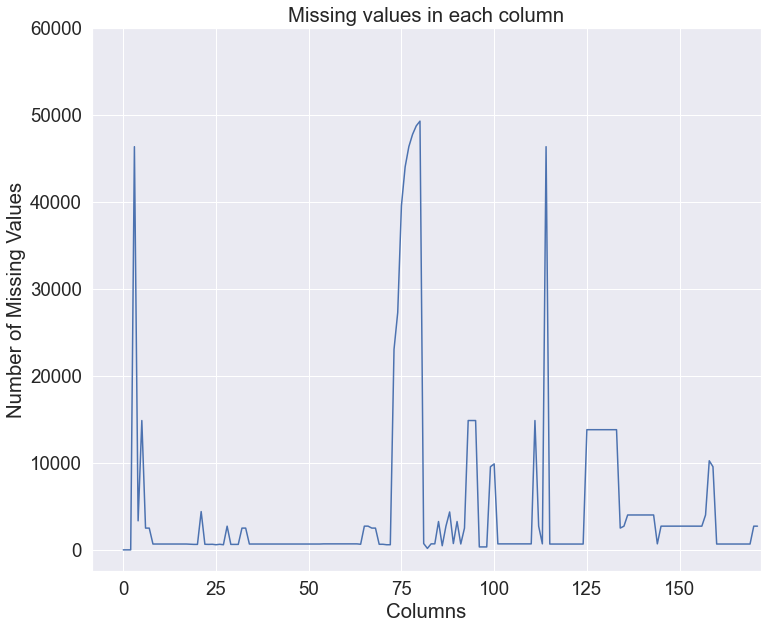

In [25]:
plt.figure(figsize=(12,10))
sns.set(font_scale=1.7)
plt.plot(range(len(df.columns)), na_cols)
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.xlim(right = df.shape[1])
plt.ylim(top = df.shape[0])
plt.title('Missing values in each column')

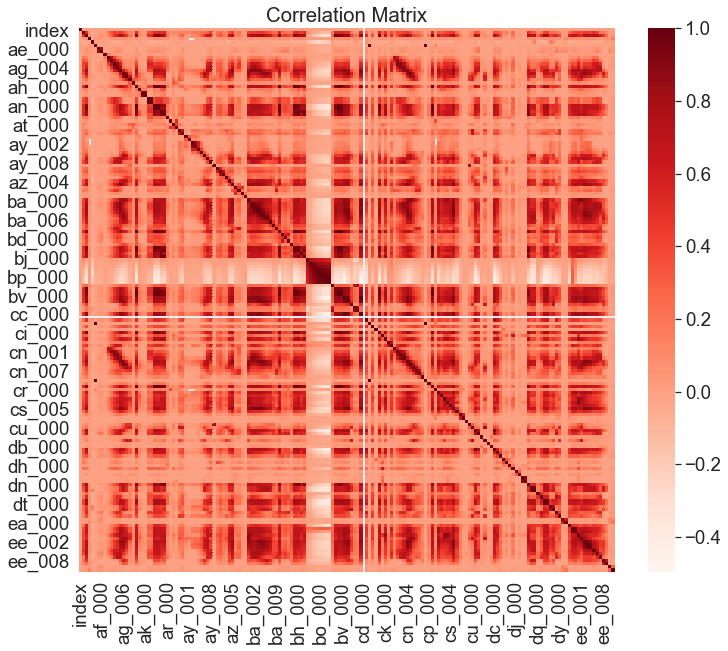

(60000, 172)


In [26]:
plt.figure(figsize=(12,10))
sns.set(font_scale=1.7)
# print(osdf.corr())
sns.heatmap(df.corr(), cmap='Reds')
plt.title('Correlation Matrix')
plt.show()
print(df.shape)

In [28]:
df, test_df = remove_high_missing_columns(df, test_df, 0.25)
df.head()

15000.0
Train data:  (60000, 162)
Test data:  (16000, 162)


,index,output,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0,0,76698,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,1,0,33058,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,2,0,41040,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,3,0,12,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,4,0,60874,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


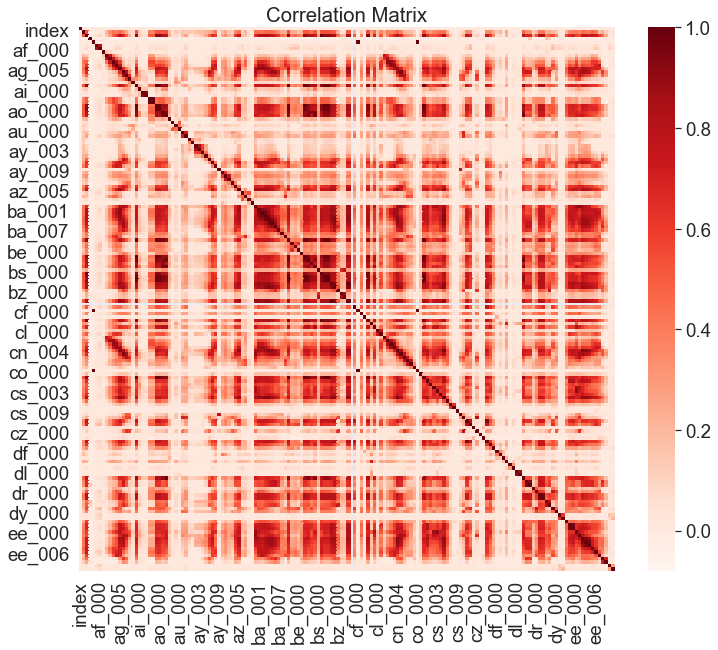

(60000, 162)


In [29]:
plt.figure(figsize=(12,10))
sns.set(font_scale=1.7)
# print(osdf.corr())
sns.heatmap(df.corr(), cmap='Reds')
plt.title('Correlation Matrix')
plt.show()
print(df.shape)

# Imputing the rest of the missing data

In [ ]:
# for col in osdf.columns:
#     col_median = osdf[col].median()
#     osdf[col] = osdf[col].fillna(col_median)

# for col in test_df.columns:
#     col_median = test_df[col].median()
#     test_df[col] = test_df[col].fillna(col_median)

# for col in osdf.columns:
#     col_mode = stats.mode(osdf[col])
# #     print(col_mode)
#     osdf[col] = osdf[col].fillna(col_mode.mode[0])

# for col in test_df.columns:
#     col_mode = test_df[col].median()
# #     print(col_mode)
#     test_df[col] = test_df[col].fillna(col_mode)

# from sklearn.impute import KNNImputer
# imputer = KNNImputer()
# imputer.fit(osdf)
# osdf = imputer.transform(osdf)

# imputer.fit(test_df)
# test_df = imputer.transform(test_df)

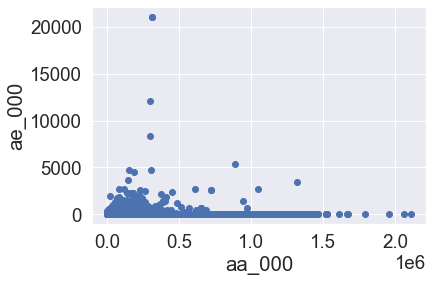

2500


In [32]:
plt.figure()
plt.scatter(df['aa_000'], df['ae_000'])
plt.xlabel('aa_000')
plt.ylabel('ae_000')
plt.show()
print(df['ae_000'].isna().sum())

In [38]:
# dropping the original index column, sorting the data frame based
# on column 'aa_000' and adding another index column after that.
df.sort_values('aa_000', inplace = True)
df = df.drop(['index'], axis=1)
indexes = np.linspace(0, df.shape[0] - 1, df.shape[0]).astype(int)
df.insert(0, "my_index", indexes, True)

test_df.sort_values('aa_000', inplace = True)
test_df = test_df.drop(['index'], axis=1)
indexes = np.linspace(0, test_df.shape[0] - 1, test_df.shape[0]).astype(int)
test_df.insert(0, "my_index", indexes, True)

In [39]:
df.describe()

,my_index,output,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,60000.000000,60000.000000,6.000000e+04,5.666500e+04,4.513900e+04,57500.000000,57500.000000,5.932900e+04,5.932900e+04,5.932900e+04,...,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,57276.000000,57277.000000
mean,29999.500000,0.016667,5.933650e+04,3.560143e+08,1.906206e+05,6.819130,11.006817,2.216364e+02,9.757223e+02,8.606015e+03,...,4.454897e+05,2.111264e+05,4.457343e+05,3.939462e+05,3.330582e+05,3.462714e+05,1.387300e+05,8.388915e+03,0.090579,0.212756
std,17320.652413,0.128020,1.454301e+05,7.948749e+08,4.040441e+07,161.543373,209.792592,2.047846e+04,3.420053e+04,1.503220e+05,...,1.155540e+06,5.433188e+05,1.168314e+06,1.121044e+06,1.069160e+06,1.728056e+06,4.495100e+05,4.747043e+04,4.368855,8.830641
min,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,14999.750000,0.000000,8.340000e+02,1.600000e+01,2.400000e+01,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,2.936000e+03,1.166000e+03,2.700000e+03,3.584000e+03,5.120000e+02,1.100000e+02,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,29999.500000,0.000000,3.077600e+04,1.520000e+02,1.260000e+02,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,2.337960e+05,1.120860e+05,2.215180e+05,1.899880e+05,9.243200e+04,4.109800e+04,3.812000e+03,0.000000e+00,0.000000,0.000000
75%,44999.250000,0.000000,4.866800e+04,9.640000e+02,4.300000e+02,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,4.383960e+05,2.182320e+05,4.666140e+05,4.032220e+05,2.750940e+05,1.678140e+05,1.397240e+05,2.028000e+03,0.000000,0.000000
max,59999.000000,1.000000,2.746564e+06,2.130707e+09,8.584298e+09,21050.000000,20070.000000,3.376892e+06,4.109372e+06,1.055286e+07,...,7.793393e+07,3.775839e+07,9.715238e+07,5.743524e+07,3.160781e+07,1.195801e+08,1.926740e+07,3.810078e+06,482.000000,1146.000000


In [40]:
df.head()

,my_index,output,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
8120,0,0,0,26.0,2.0,0.0,0.0,0.0,0.0,0.0,...,276.0,30.0,36.0,16.0,6.0,2.0,0.0,0.0,0.0,0.0
10144,1,0,0,NaN,28.0,NaN,NaN,0.0,0.0,0.0,...,3940.0,1180.0,2036.0,2454.0,2354.0,3736.0,10.0,0.0,NaN,NaN
42500,2,0,0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,...,1112.0,426.0,394.0,524.0,148.0,244.0,0.0,0.0,0.0,0.0
23422,3,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8460,4,0,0,NaN,608.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
test_df.head()

,my_index,output,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
8857,0,0,0,18.0,18.0,0.0,0.0,0.0,0.0,0.0,...,9482.0,4200.0,8564.0,12022.0,79418.0,20440.0,408.0,0.0,0.0,0.0
9770,1,0,0,NaN,124.0,NaN,NaN,0.0,0.0,0.0,...,6124.0,2600.0,8466.0,114612.0,156.0,26.0,0.0,0.0,NaN,NaN
9325,2,0,0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,...,194.0,48.0,46.0,32.0,16.0,10.0,0.0,0.0,0.0,0.0
13344,3,0,0,80.0,NaN,0.0,0.0,0.0,0.0,0.0,...,128.0,66.0,118.0,102.0,78.0,20.0,0.0,0.0,0.0,0.0
3261,4,0,0,12.0,14.0,0.0,0.0,0.0,0.0,0.0,...,154.0,18.0,32.0,20.0,2.0,0.0,0.0,0.0,0.0,0.0


In [42]:
df = lin_imputation(df)

Imputing column[3]: ac_000, current_col size= 56665


<ipython-input-13-ab3efb115626>:205: RuntimeWarning: divide by zero encountered in double_scalars
  fixed_part = (next_row_col - prev_row_col) / (next_row_1 - prev_row_1)
<ipython-input-13-ab3efb115626>:207: RuntimeWarning: invalid value encountered in multiply
  mydf.iat[j, col] = prev_row_col + ((first_col.iloc[j] - prev_row_1) * fixed_part)
<ipython-input-13-ab3efb115626>:205: RuntimeWarning: invalid value encountered in double_scalars
  fixed_part = (next_row_col - prev_row_col) / (next_row_1 - prev_row_1)


Imputing column[4]: ad_000, current_col size= 45139
Imputing column[5]: ae_000, current_col size= 57500
Imputing column[6]: af_000, current_col size= 57500
Imputing column[7]: ag_000, current_col size= 59329
Imputing column[8]: ag_001, current_col size= 59329
Imputing column[9]: ag_002, current_col size= 59329
Imputing column[10]: ag_003, current_col size= 59329
Imputing column[11]: ag_004, current_col size= 59329
Imputing column[12]: ag_005, current_col size= 59329
Imputing column[13]: ag_006, current_col size= 59329
Imputing column[14]: ag_007, current_col size= 59329
Imputing column[15]: ag_008, current_col size= 59329
Imputing column[16]: ag_009, current_col size= 59329
Imputing column[17]: ah_000, current_col size= 59355
Imputing column[18]: ai_000, current_col size= 59371
Imputing column[19]: aj_000, current_col size= 59371
Imputing column[20]: ak_000, current_col size= 55600
Imputing column[21]: al_000, current_col size= 59358
Imputing column[22]: am_0, current_col size= 59371
I

Imputing column[158]: ee_008, current_col size= 59329
Imputing column[159]: ee_009, current_col size= 59329
Imputing column[160]: ef_000, current_col size= 57276
Imputing column[161]: eg_000, current_col size= 57277


In [43]:
test_df = lin_imputation(test_df)

Imputing column[3]: ac_000, current_col size= 15074


<ipython-input-13-ab3efb115626>:205: RuntimeWarning: divide by zero encountered in double_scalars
  fixed_part = (next_row_col - prev_row_col) / (next_row_1 - prev_row_1)
<ipython-input-13-ab3efb115626>:207: RuntimeWarning: invalid value encountered in multiply
  mydf.iat[j, col] = prev_row_col + ((first_col.iloc[j] - prev_row_1) * fixed_part)
<ipython-input-13-ab3efb115626>:205: RuntimeWarning: invalid value encountered in double_scalars
  fixed_part = (next_row_col - prev_row_col) / (next_row_1 - prev_row_1)


Imputing column[4]: ad_000, current_col size= 12019
Imputing column[5]: ae_000, current_col size= 15310
Imputing column[6]: af_000, current_col size= 15310
Imputing column[7]: ag_000, current_col size= 15811
Imputing column[8]: ag_001, current_col size= 15811
Imputing column[9]: ag_002, current_col size= 15811
Imputing column[10]: ag_003, current_col size= 15811
Imputing column[11]: ag_004, current_col size= 15811
Imputing column[12]: ag_005, current_col size= 15811
Imputing column[13]: ag_006, current_col size= 15811
Imputing column[14]: ag_007, current_col size= 15811
Imputing column[15]: ag_008, current_col size= 15811
Imputing column[16]: ag_009, current_col size= 15811
Imputing column[17]: ah_000, current_col size= 15825
Imputing column[18]: ai_000, current_col size= 15837
Imputing column[19]: aj_000, current_col size= 15837
Imputing column[20]: ak_000, current_col size= 14802
Imputing column[21]: al_000, current_col size= 15831
Imputing column[22]: am_0, current_col size= 15837
I

Imputing column[158]: ee_008, current_col size= 15808
Imputing column[159]: ee_009, current_col size= 15808
Imputing column[160]: ef_000, current_col size= 15238
Imputing column[161]: eg_000, current_col size= 15238


In [44]:
# df.to_csv('df.csv')
# test_df.to_csv('test_df.csv')

## Start from this point after loading helper functions

In [11]:
new_df = pd.read_csv("df.csv", delimiter=',')
new_test_df = pd.read_csv("test_df.csv", delimiter=',')

In [12]:
new_df.describe()

,Unnamed: 0,my_index,output,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,60000.000000,60000.000000,60000.000000,6.000000e+04,5.953600e+04,5.555700e+04,59713.000000,59713.000000,5.962200e+04,5.962200e+04,...,5.962200e+04,5.962200e+04,5.962200e+04,5.962200e+04,5.962200e+04,5.962200e+04,5.962200e+04,5.962200e+04,59675.00000,59676.000000
mean,29999.500000,29999.500000,0.016667,5.933650e+04,3.490098e+08,1.550618e+05,7.602299,12.668610,2.235078e+02,1.009295e+03,...,4.475803e+05,2.120575e+05,4.476777e+05,3.958116e+05,3.346077e+05,3.476607e+05,1.390120e+05,8.406969e+03,0.09310,0.216324
std,17320.652413,17320.652413,0.128020,1.454301e+05,7.854823e+08,3.641962e+07,161.361717,215.302357,2.043749e+04,3.473791e+04,...,1.157847e+06,5.440421e+05,1.169611e+06,1.123509e+06,1.069947e+06,1.727668e+06,4.493006e+05,4.742998e+04,4.32257,8.692095
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00000,0.000000
25%,14999.750000,14999.750000,0.000000,8.340000e+02,1.800000e+01,3.200000e+01,0.000000,0.000000,0.000000e+00,0.000000e+00,...,2.970500e+03,1.180000e+03,2.740500e+03,3.665000e+03,5.260000e+02,1.120000e+02,0.000000e+00,0.000000e+00,0.00000,0.000000
50%,29999.500000,29999.500000,0.000000,3.077600e+04,1.660000e+02,1.700000e+02,0.000000,0.000000,0.000000e+00,0.000000e+00,...,2.348730e+05,1.125990e+05,2.225070e+05,1.908670e+05,9.366900e+04,4.147200e+04,3.951000e+03,0.000000e+00,0.00000,0.000000
75%,44999.250000,44999.250000,0.000000,4.866800e+04,1.066000e+03,5.260000e+02,0.000000,0.000000,0.000000e+00,0.000000e+00,...,4.395915e+05,2.189405e+05,4.677380e+05,4.044210e+05,2.762600e+05,1.682635e+05,1.399220e+05,2.042000e+03,0.00000,0.000000
max,59999.000000,59999.000000,1.000000,2.746564e+06,2.130707e+09,8.584298e+09,21050.000000,20070.000000,3.376892e+06,4.109372e+06,...,7.793393e+07,3.775839e+07,9.715238e+07,5.743524e+07,3.160781e+07,1.195801e+08,1.926740e+07,3.810078e+06,482.00000,1146.000000


In [13]:
new_test_df.describe()

,Unnamed: 0,my_index,output,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,16000.000000,16000.000000,16000.000000,1.600000e+04,1.593400e+04,15389.000000,15967.000000,15967.000000,15922.000000,1.592200e+04,...,1.592200e+04,1.592200e+04,1.592200e+04,1.592200e+04,1.592200e+04,1.592200e+04,1.592200e+04,1.592200e+04,15960.000000,15960.000000
mean,7999.500000,7999.500000,0.023438,6.799698e+04,3.513117e+08,525.067896,7.072248,11.482487,120.015953,2.057035e+03,...,4.672667e+05,2.224432e+05,4.715500e+05,4.286414e+05,3.594799e+05,3.566079e+05,1.446478e+05,8.562852e+03,0.065735,0.252729
std,4618.946489,4618.946489,0.151293,5.035350e+05,7.863210e+08,1645.208979,118.610768,171.617841,6432.128105,8.894878e+04,...,1.255145e+06,5.832886e+05,1.267470e+06,1.263591e+06,1.208386e+06,1.635682e+06,5.355503e+05,5.317785e+04,3.299548,14.029489
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,3999.750000,3999.750000,0.000000,9.280000e+02,1.800000e+01,32.000000,0.000000,0.000000,0.000000,0.000000e+00,...,3.234000e+03,1.278000e+03,2.956000e+03,3.972000e+03,6.320000e+02,1.300000e+02,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,7999.500000,7999.500000,0.000000,3.098200e+04,1.769610e+02,176.000000,0.000000,0.000000,0.000000,0.000000e+00,...,2.420020e+05,1.153630e+05,2.308590e+05,1.968200e+05,9.833600e+04,4.239100e+04,4.158000e+03,0.000000e+00,0.000000,0.000000
75%,11999.250000,11999.250000,0.000000,4.947900e+04,1.110000e+03,522.000000,0.000000,0.000000,0.000000,0.000000e+00,...,4.408285e+05,2.199655e+05,4.743560e+05,4.054625e+05,2.797570e+05,1.707635e+05,1.397045e+05,1.925000e+03,0.000000,0.000000
max,15999.000000,15999.000000,1.000000,4.294967e+07,2.130707e+09,87038.000000,11044.000000,14186.000000,736174.000000,1.047252e+07,...,5.382333e+07,2.207969e+07,4.859750e+07,5.604348e+07,4.215944e+07,4.747137e+07,1.718575e+07,4.570398e+06,340.000000,1720.000000


In [14]:
new_df.drop(new_df.columns[0:2], axis = 1, inplace = True)
new_test_df.drop(new_test_df.columns[0:2], axis = 1, inplace = True)

In [15]:
new_df.describe()

,output,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,60000.000000,6.000000e+04,5.953600e+04,5.555700e+04,59713.000000,59713.000000,5.962200e+04,5.962200e+04,5.962200e+04,5.962200e+04,...,5.962200e+04,5.962200e+04,5.962200e+04,5.962200e+04,5.962200e+04,5.962200e+04,5.962200e+04,5.962200e+04,59675.00000,59676.000000
mean,0.016667,5.933650e+04,3.490098e+08,1.550618e+05,7.602299,12.668610,2.235078e+02,1.009295e+03,8.736826e+03,8.941132e+04,...,4.475803e+05,2.120575e+05,4.476777e+05,3.958116e+05,3.346077e+05,3.476607e+05,1.390120e+05,8.406969e+03,0.09310,0.216324
std,0.128020,1.454301e+05,7.854823e+08,3.641962e+07,161.361717,215.302357,2.043749e+04,3.473791e+04,1.510016e+05,7.633514e+05,...,1.157847e+06,5.440421e+05,1.169611e+06,1.123509e+06,1.069947e+06,1.727668e+06,4.493006e+05,4.742998e+04,4.32257,8.692095
min,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,-9.094947e-13,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00000,0.000000
25%,0.000000,8.340000e+02,1.800000e+01,3.200000e+01,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.970500e+03,1.180000e+03,2.740500e+03,3.665000e+03,5.260000e+02,1.120000e+02,0.000000e+00,0.000000e+00,0.00000,0.000000
50%,0.000000,3.077600e+04,1.660000e+02,1.700000e+02,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.348730e+05,1.125990e+05,2.225070e+05,1.908670e+05,9.366900e+04,4.147200e+04,3.951000e+03,0.000000e+00,0.00000,0.000000
75%,0.000000,4.866800e+04,1.066000e+03,5.260000e+02,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,4.395915e+05,2.189405e+05,4.677380e+05,4.044210e+05,2.762600e+05,1.682635e+05,1.399220e+05,2.042000e+03,0.00000,0.000000
max,1.000000,2.746564e+06,2.130707e+09,8.584298e+09,21050.000000,20070.000000,3.376892e+06,4.109372e+06,1.055286e+07,6.340207e+07,...,7.793393e+07,3.775839e+07,9.715238e+07,5.743524e+07,3.160781e+07,1.195801e+08,1.926740e+07,3.810078e+06,482.00000,1146.000000


In [16]:
new_test_df.describe()

,output,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,16000.000000,1.600000e+04,1.593400e+04,15389.000000,15967.000000,15967.000000,15922.000000,1.592200e+04,1.592200e+04,1.592200e+04,...,1.592200e+04,1.592200e+04,1.592200e+04,1.592200e+04,1.592200e+04,1.592200e+04,1.592200e+04,1.592200e+04,15960.000000,15960.000000
mean,0.023438,6.799698e+04,3.513117e+08,525.067896,7.072248,11.482487,120.015953,2.057035e+03,1.391865e+04,1.136610e+05,...,4.672667e+05,2.224432e+05,4.715500e+05,4.286414e+05,3.594799e+05,3.566079e+05,1.446478e+05,8.562852e+03,0.065735,0.252729
std,0.151293,5.035350e+05,7.863210e+08,1645.208979,118.610768,171.617841,6432.128105,8.894878e+04,2.355283e+05,1.027844e+06,...,1.255145e+06,5.832886e+05,1.267470e+06,1.263591e+06,1.208386e+06,1.635682e+06,5.355503e+05,5.317785e+04,3.299548,14.029489
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,0.000000,9.280000e+02,1.800000e+01,32.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,3.234000e+03,1.278000e+03,2.956000e+03,3.972000e+03,6.320000e+02,1.300000e+02,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,0.000000,3.098200e+04,1.769610e+02,176.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,2.420020e+05,1.153630e+05,2.308590e+05,1.968200e+05,9.833600e+04,4.239100e+04,4.158000e+03,0.000000e+00,0.000000,0.000000
75%,0.000000,4.947900e+04,1.110000e+03,522.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,4.408285e+05,2.199655e+05,4.743560e+05,4.054625e+05,2.797570e+05,1.707635e+05,1.397045e+05,1.925000e+03,0.000000,0.000000
max,1.000000,4.294967e+07,2.130707e+09,87038.000000,11044.000000,14186.000000,736174.000000,1.047252e+07,1.914916e+07,7.305747e+07,...,5.382333e+07,2.207969e+07,4.859750e+07,5.604348e+07,4.215944e+07,4.747137e+07,1.718575e+07,4.570398e+06,340.000000,1720.000000


## There are some missing values that are not imputed. I replace them with median of the corresponding column.

In [17]:
na_cols = new_df.isna().sum()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(na_cols.sort_values(ascending = False))

ch_000    4443
cg_000    4443
co_000    4443
cf_000    4443
ad_000    4443
cv_000    4314
da_000    4314
cz_000    4314
cy_000    4314
cx_000    4314
cu_000    4314
dc_000    4314
ct_000    4314
db_000    4314
ec_00     3458
cm_000    3381
ed_000    3220
cl_000    3220
ak_000     816
ca_000     801
cc_000     770
bx_000     769
dh_000     597
dm_000     597
dl_000     597
eb_000     596
df_000     596
dg_000     596
dj_000     596
dk_000     595
di_000     595
ac_000     464
cn_006     390
ba_002     390
cn_007     390
cn_008     390
cn_009     390
cn_005     390
cn_004     390
cn_003     390
ba_008     390
ba_000     390
ba_001     390
ba_007     390
ba_005     390
ba_003     390
ba_004     390
ba_006     390
cn_002     390
cn_001     390
cn_000     390
ba_009     390
az_007     378
az_005     378
az_004     378
az_003     378
az_006     378
ay_004     378
ag_007     378
ag_008     378
ag_009     378
az_008     378
az_009     378
ay_000     378
ay_001     378
ay_002     378
ay_003    

In [18]:
na_test_cols = new_test_df.isna().sum()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(na_test_cols.sort_values(ascending = False))

cg_000    611
co_000    611
cf_000    611
ch_000    611
ad_000    611
dc_000    602
da_000    602
cz_000    602
cy_000    602
cx_000    602
cv_000    602
cu_000    602
ct_000    602
db_000    602
cm_000    574
ec_00     546
ed_000    520
cl_000    520
ca_000    105
ak_000     96
ba_000     80
ba_007     80
ba_006     80
ba_005     80
ba_004     80
ba_003     80
ba_002     80
ba_001     80
ba_009     80
cn_008     80
cn_009     80
cn_007     80
cn_006     80
cn_005     80
cn_004     80
cn_003     80
cn_002     80
cn_001     80
cn_000     80
ba_008     80
dl_000     79
df_000     79
dg_000     79
dh_000     79
di_000     79
dj_000     79
eb_000     79
dk_000     79
dm_000     79
ee_001     78
az_007     78
az_006     78
ag_008     78
ag_007     78
ag_000     78
az_005     78
ag_006     78
az_004     78
ee_000     78
ag_005     78
az_009     78
az_008     78
ag_009     78
ag_004     78
ee_002     78
ee_003     78
ee_004     78
ee_005     78
ee_006     78
ee_007     78
ee_008     78
ee_009

In [19]:
for col in new_df.columns:
    col_median = new_df[col].median()
    new_df[col] = new_df[col].fillna(col_median)

for col in new_test_df.columns:
    col_median = new_test_df[col].median()
    new_test_df[col] = new_test_df[col].fillna(col_median)

In [20]:
na_cols = new_df.isna().sum()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(na_cols.sort_values(ascending = False))

eg_000    0
cb_000    0
ba_005    0
ba_004    0
ba_003    0
ba_002    0
ba_001    0
ba_000    0
az_009    0
az_008    0
az_007    0
az_006    0
az_005    0
az_004    0
az_003    0
az_002    0
az_001    0
az_000    0
ay_009    0
ba_006    0
ba_007    0
ba_008    0
bj_000    0
bz_000    0
by_000    0
bx_000    0
bv_000    0
bu_000    0
bt_000    0
bs_000    0
bi_000    0
ba_009    0
bh_000    0
bg_000    0
bf_000    0
be_000    0
bd_000    0
bc_000    0
bb_000    0
ay_008    0
ay_007    0
ay_006    0
ag_003    0
ah_000    0
ag_009    0
ag_008    0
ag_007    0
ag_006    0
ag_005    0
ag_004    0
ag_002    0
aj_000    0
ag_001    0
ag_000    0
af_000    0
ae_000    0
ad_000    0
ac_000    0
aa_000    0
ai_000    0
ak_000    0
ay_005    0
au_000    0
ay_004    0
ay_003    0
ay_002    0
ay_001    0
ay_000    0
ax_000    0
av_000    0
at_000    0
al_000    0
as_000    0
ar_000    0
aq_000    0
ap_000    0
ao_000    0
an_000    0
am_0      0
ca_000    0
cc_000    0
ef_000    0
cd_000    0
ds_0

In [21]:
na_test_cols = new_test_df.isna().sum()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(na_test_cols.sort_values(ascending = False))

eg_000    0
cb_000    0
ba_005    0
ba_004    0
ba_003    0
ba_002    0
ba_001    0
ba_000    0
az_009    0
az_008    0
az_007    0
az_006    0
az_005    0
az_004    0
az_003    0
az_002    0
az_001    0
az_000    0
ay_009    0
ba_006    0
ba_007    0
ba_008    0
bj_000    0
bz_000    0
by_000    0
bx_000    0
bv_000    0
bu_000    0
bt_000    0
bs_000    0
bi_000    0
ba_009    0
bh_000    0
bg_000    0
bf_000    0
be_000    0
bd_000    0
bc_000    0
bb_000    0
ay_008    0
ay_007    0
ay_006    0
ag_003    0
ah_000    0
ag_009    0
ag_008    0
ag_007    0
ag_006    0
ag_005    0
ag_004    0
ag_002    0
aj_000    0
ag_001    0
ag_000    0
af_000    0
ae_000    0
ad_000    0
ac_000    0
aa_000    0
ai_000    0
ak_000    0
ay_005    0
au_000    0
ay_004    0
ay_003    0
ay_002    0
ay_001    0
ay_000    0
ax_000    0
av_000    0
at_000    0
al_000    0
as_000    0
ar_000    0
aq_000    0
ap_000    0
ao_000    0
an_000    0
am_0      0
ca_000    0
cc_000    0
ef_000    0
cd_000    0
ds_0

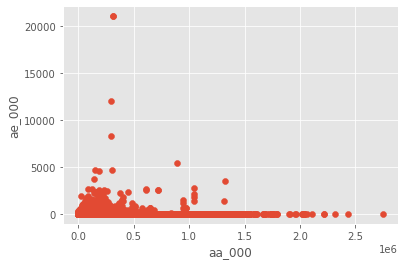

0.0


In [22]:
plt.figure()
plt.scatter(new_df['aa_000'], new_df['ae_000'])
plt.xlabel('aa_000')
plt.ylabel('ae_000')
plt.show()
print(np.mean(new_df['ae_000'] == -20000) * 118000)

In [23]:
find_inf_nan_onevalues(new_df)

find_inf_nan_onevalues(new_test_df)

Column: cd_000 has only one value!
Done
Column: cd_000 has only one value!
Done


In [24]:
new_df = new_df.drop(columns = 'cd_000', axis=1)
new_test_df = new_test_df.drop(columns = 'cd_000', axis=1)

print(new_df.shape)
print(new_test_df.shape)

(60000, 160)
(16000, 160)


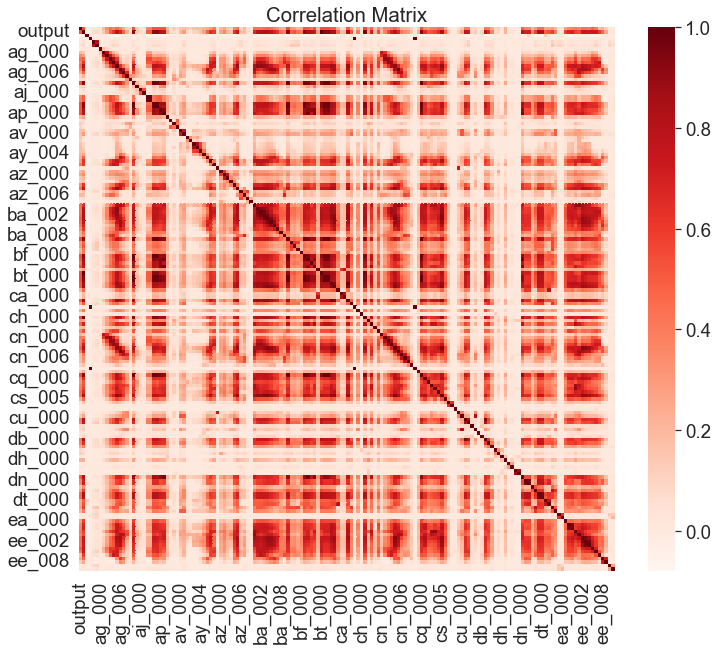

(60000, 160)


In [25]:
plt.figure(figsize=(12,10))
sns.set(font_scale=1.7)
# print(osdf.corr())
sns.heatmap(new_df.corr(), cmap='Reds')
plt.title('Correlation Matrix')
plt.show()
print(new_df.shape)

# Reducing the number of columns
Columns that have little correlation with the output are removed from the dataframe. I have decided to only keep 20 columns.

In [26]:
print(new_df.shape)
print(new_test_df.shape)

reduced_df = new_df.copy(deep=True)
reduced_test_df = new_test_df.copy(deep=True)

osdf_corr = reduced_df.corr()
row, col = osdf_corr.shape
cols = osdf_corr.columns
cols_list = list(cols)

output_corr_dict = dict()
for i in range(1, col):
    output_corr_dict[cols[i]] = abs(osdf_corr.loc[cols[0], cols[i]])
    
output_corr_dict = dict(sorted(output_corr_dict.items(), reverse = True, key=lambda item: item[1]))   
chosen_cols = ['output']
dict_keys = list(output_corr_dict.keys())
while len(output_corr_dict) > 0:
    highest_output_corr = dict_keys[0]
    dict_keys.pop(0)
    chosen_cols.append(highest_output_corr)
    output_corr_dict.pop(highest_output_corr)
    item_list = list(output_corr_dict.items())
    for item in item_list:
        if osdf_corr.loc[highest_output_corr, item[0]] > 0.95:
            dict_keys.remove(item[0])
            output_corr_dict.pop(item[0])
print('chosen_cols size is originally:', len(chosen_cols))
if len(chosen_cols) > 21:
    chosen_cols = chosen_cols[:21]
print('Selected columns:')
for col in chosen_cols:
    print(col)

reduced_df = reduced_df[chosen_cols].copy()
reduced_test_df = reduced_test_df[chosen_cols].copy()

print(reduced_df.shape)
print(reduced_test_df.shape)

(60000, 160)
(16000, 160)
chosen_cols size is originally: 138
Selected columns:
output
ci_000
bb_000
aq_000
ap_000
cc_000
by_000
ee_005
ba_004
cn_004
ck_000
ds_000
ba_005
ag_005
ee_002
cs_005
ba_001
cs_004
ag_003
az_005
bi_000
(60000, 21)
(16000, 21)


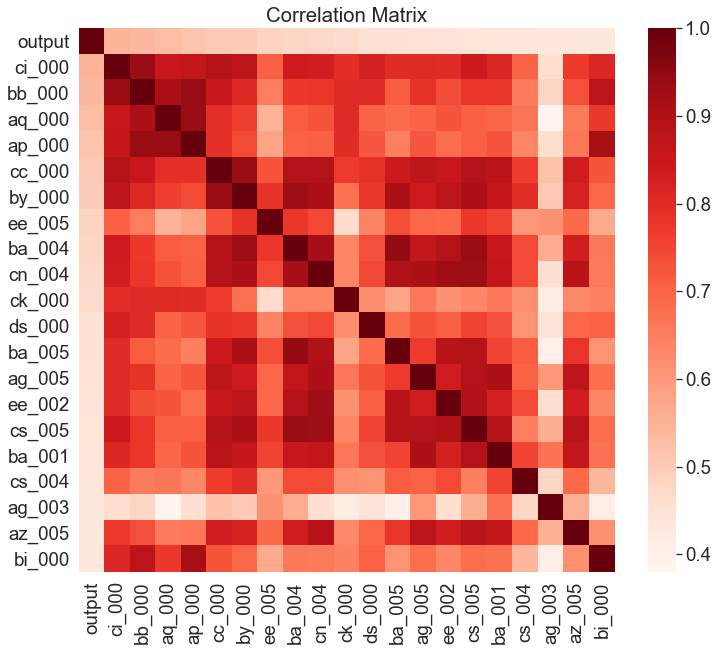

(60000, 21)


In [27]:
plt.figure(figsize=(12,10))
sns.set(font_scale=1.7)
# print(reduced_df.corr())
sns.heatmap(reduced_df.corr(), cmap='Reds')
plt.title('Correlation Matrix')
plt.show()
print(reduced_df.shape)

# Applying SMOTE to oversample positive samples.

In [28]:
reduced_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   output  60000 non-null  int64  
 1   ci_000  60000 non-null  float64
 2   bb_000  60000 non-null  float64
 3   aq_000  60000 non-null  float64
 4   ap_000  60000 non-null  float64
 5   cc_000  60000 non-null  float64
 6   by_000  60000 non-null  float64
 7   ee_005  60000 non-null  float64
 8   ba_004  60000 non-null  float64
 9   cn_004  60000 non-null  float64
 10  ck_000  60000 non-null  float64
 11  ds_000  60000 non-null  float64
 12  ba_005  60000 non-null  float64
 13  ag_005  60000 non-null  float64
 14  ee_002  60000 non-null  float64
 15  cs_005  60000 non-null  float64
 16  ba_001  60000 non-null  float64
 17  cs_004  60000 non-null  float64
 18  ag_003  60000 non-null  float64
 19  az_005  60000 non-null  float64
 20  bi_000  60000 non-null  float64
dtypes: float64(20), int64(1)
memory usa

In [29]:
reduced_df['output'] = reduced_df['output'].astype(int)
reduced_test_df['output'] = reduced_test_df['output'].astype(int)
reduced_df_output = reduced_df['output'].copy(deep=True)
reduced_test_df_output = reduced_test_df['output'].copy(deep=True)
reduced_train_data = reduced_df.to_numpy()
reduced_test_data = reduced_test_df.to_numpy()

reduced_y_train = reduced_df_output.to_numpy()
reduced_y_test = reduced_test_df_output.to_numpy()
reduced_X_train = reduced_train_data[:, 1:]
reduced_X_test = reduced_test_data[:, 1:]

In [30]:
reduced_X_test.shape

(16000, 20)

In [31]:
from collections import Counter
from imblearn.over_sampling import SMOTE

# summarize class distribution before oversampling
counter = Counter(reduced_y_train)
print(counter)

Counter({0: 59000, 1: 1000})


In [32]:
# transform the train set.
oversample = SMOTE(random_state = 101)
reduced_X_train, reduced_y_train = oversample.fit_resample(reduced_X_train, reduced_y_train)

In [33]:
# summarize class distribution after oversampling
counter = Counter(reduced_y_train)
print(counter)

Counter({0: 59000, 1: 59000})


In [34]:
reduced_X_train.shape

(118000, 20)

## Applying SMOTE to the original data set

In [35]:
# Applying SMOTE to the original data set.
new_df['output'] = new_df['output'].astype(int)
new_test_df['output'] = new_test_df['output'].astype(int)
df_output = new_df['output'].copy(deep=True)
test_df_output = new_test_df['output'].copy(deep=True)
train_data = new_df.to_numpy()
test_data = new_test_df.to_numpy()

y_train = df_output.to_numpy()
y_test = test_df_output.to_numpy()
X_train = train_data[:, 1:]
X_test = test_data[:, 1:]

In [36]:
# summarize class distribution before oversampling
counter = Counter(y_train)
print(counter)

Counter({0: 59000, 1: 1000})


In [37]:
# transform the train set.
oversample = SMOTE(random_state = 101)
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [38]:
# summarize class distribution after oversampling
counter = Counter(y_train)
print(counter)

Counter({0: 59000, 1: 59000})


# Normalization of data

## Normalizing original data

In [39]:
X_train = aray_min_max_normalization(X_train)
X_test = aray_min_max_normalization(X_test)

In [40]:
X_train.shape

(118000, 159)

In [41]:
X_test.shape

(16000, 159)

## Normalizing the reduced data

In [42]:
reduced_X_train = aray_min_max_normalization(reduced_X_train)
reduced_X_test = aray_min_max_normalization(reduced_X_test)

In [43]:
print(reduced_X_train.shape)
print(reduced_X_test.shape)

(118000, 20)
(16000, 20)


# Fitting a Logistic Regression model with the training data

## Logistic Regression with original data

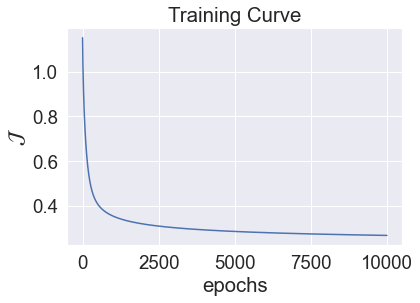

true_pos= 351, false_neg= 24, false_pos= 2028, true_neg= 13597
{'accuracy': 87.17, 'precision': 0.1475, 'sensitivity': 0.936, 'specifity': 0.8702, 'recall': 0.936, 'npv': 0.9982, 'f1': 0.2548}


In [44]:
log_reg = MVLogisticRegression()
log_reg.fit(X_train, y_train.astype(int), eta = 1e-1, epochs = 1e4, show_curve = True)
y_hat_log_r = log_reg.predict(X_test)
print(get_metrics(y_test, y_hat_log_r))

(16000,)
(16000,)


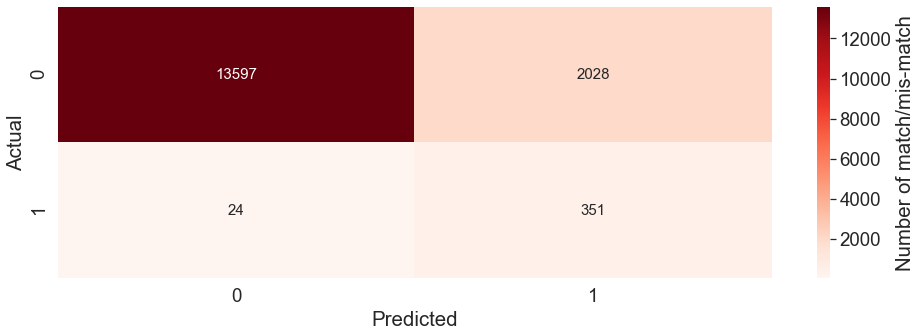

In [45]:
print(y_test.shape)
print(y_hat_log_r.shape)
confusion_matrix = pd.crosstab(y_test.reshape(y_test.shape[0],), y_hat_log_r, rownames=['Actual'], colnames=['Predicted'])

sns.set(font_scale=1.7)
plt.figure(figsize=(16,5))
heatmap = sns.heatmap(confusion_matrix, cmap='Reds', fmt=".0f", annot=True, annot_kws={"size": 15},
                    cbar_kws={'label': 'Number of match/mis-match'})
plt.show()

In [47]:
print(f'Total cost= {(25 * 500 + 2027 * 10)}') # With epochs = 1e4 with SMOTE()
print(f'Total cost= {(24 * 500 + 1538 * 10)}') # With epochs = 5e4 with SMOTE()
print(f'Total cost= {(24 * 500 + 2028 * 10)}') # With epochs = 1e4 with SMOTE(random_state = 101) f1 = 0.2548

Total cost= 32770
Total cost= 27380
Total cost= 32280


## Logistic Regression with reduced data

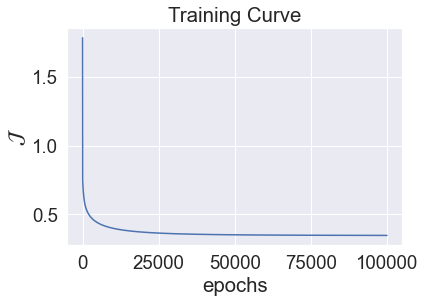

true_pos= 317, false_neg= 58, false_pos= 1935, true_neg= 13690
{'accuracy': 87.54, 'precision': 0.1408, 'sensitivity': 0.8453, 'specifity': 0.8762, 'recall': 0.8453, 'npv': 0.9958, 'f1': 0.2414}


In [76]:
log_reg = MVLogisticRegression()
log_reg.fit(reduced_X_train, reduced_y_train.astype(int), eta = 1e-1, epochs = 1e5, show_curve = True)
reduced_y_hat_log_r = log_reg.predict(reduced_X_test)
print(get_metrics(reduced_y_test, reduced_y_hat_log_r))

In [ ]:
print(reduced_y_test.shape)
print(reduced_y_hat_log_r.shape)
confusion_matrix = pd.crosstab(reduced_y_test.reshape(reduced_y_test.shape[0],), reduced_y_hat_log_r, rownames=['Actual'], colnames=['Predicted'])

sns.set(font_scale=1.7)
plt.figure(figsize=(16,5))
heatmap = sns.heatmap(confusion_matrix, cmap='Reds', fmt=".0f", annot=True, annot_kws={"size": 15},
                    cbar_kws={'label': 'Number of match/mis-match'})
plt.show()

In [78]:
print(f'Total cost= {(57 * 500 + 1946 * 10)}') # With epochs = 1e4, eta = 1e-1, SMOTE()
print(f'Total cost= {(133 * 500 + 5339 * 10)}') # With epochs = 1e4, eta = 1e-3, SMOTE()
print(f'Total cost= {(57 * 500 + 1920 * 10)}') # With epochs = 5e4, eta = 1e-1, SMOTE()
print(f'Total cost= {(58 * 500 + 1935 * 10)}') # With epochs = 1e5, eta = 1e-1, SMOTE() f1 = 0.2414
print(f'Total cost= {( * 500 +  * 10)}') # With epochs = 1e5, eta = 1e-1 With SMOTE(random_state = 101) f1 = 

Total cost= 47960
Total cost= 119890
Total cost= 47700
Total cost= 48350


## Non-Naive Gaussian Bayes Classifier

In [106]:
gb = GaussBernoulli()
reduced_y_hat_log_r = numpy_fit_predict(reduced_X_train, reduced_y_train, reduced_X_test, reduced_y_test, gb)

true_pos= 343, false_neg= 32, false_pos= 3714, true_neg= 11911
{'accuracy': 76.59, 'precision': 0.0845, 'sensitivity': 0.9147, 'specifity': 0.7623, 'recall': 0.9147, 'npv': 0.9973, 'f1': 0.1547}


(16000,)
(16000,)


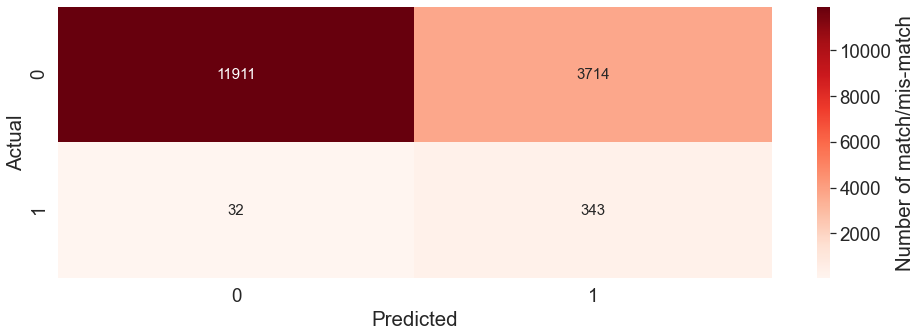

In [107]:
print(reduced_y_test.shape)
print(reduced_y_hat_log_r.shape)
confusion_matrix = pd.crosstab(reduced_y_test.reshape(reduced_y_test.shape[0],), reduced_y_hat_log_r, rownames=['Actual'], colnames=['Predicted'])

sns.set(font_scale=1.7)
plt.figure(figsize=(16,5))
heatmap = sns.heatmap(confusion_matrix, cmap='Reds', fmt=".0f", annot=True, annot_kws={"size": 15},
                    cbar_kws={'label': 'Number of match/mis-match'})
plt.show()

In [108]:
print(f'Total cost= {(32 * 500 + 3714 * 10)}') # With Non-Naive Gaussian Bayes Classifier

Total cost= 53140


# Redundant older codes

In [79]:
# osdf = over_sample(df, 58)

# osdf = over_sample(df, 58)

In [80]:
# missing_cols_dict = {}
# row, col = osdf.shape
# for col_count in range(col, 0, -1):
#     new_df = osdf.dropna(axis = 0, inplace = False, thresh = col_count)
#     temp_row, temp_col = new_df.shape
#     missing_cols_dict[col_count] = temp_row

# plt.figure(figsize=(12,10))
# sns.set(font_scale=1.7)
# plt.plot(missing_cols_dict.keys(), missing_cols_dict.values())
# plt.xlabel('Non-Missing Columns')
# plt.ylabel('Number of Rows')
# plt.title('Rows with given number of valid columns')
# print(missing_cols_dict)

In [81]:
# missing_cols_2_dict = {}
# row, col = osdf.shape
# print(osdf.shape)
# for col_count in range(col, 0, -1):
#     new_df = osdf.dropna(axis = 0, inplace = False, thresh = col_count)
#     temp_row, temp_col = new_df.shape
#     missing_cols_2_dict[col_count] = temp_row

# plt.figure(figsize=(12,10))
# sns.set(font_scale=1.7)
# plt.plot(missing_cols_2_dict.keys(), missing_cols_2_dict.values())
# plt.xlabel('Non-Missing Columns')
# plt.ylabel('Number of Rows')
# plt.title('Rows with given number of valid columns')
# print(missing_cols_2_dict)

# Imputing the Missing Values Using KNN Imputer
There is one input column that has no missing value

In [82]:
# pd.DataFrame(osdf).to_csv("osdf.csv")
# pd.DataFrame(test_df).to_csv("test_df.csv")

In [83]:
# import fancyimpute
# from fancyimpute import KNN

# for col in osdf.columns:
#     knn_osdf[col] = KNN(k=5).fit_transform(osdf[col])

# for col in osdf.columns:
#     knn_test_df[col] = KNN(k=5).fit_transform(test_df[col])

# pd.DataFrame(knn_osdf).to_csv("knn_imputed_osdf.csv")
# pd.DataFrame(knn_test_df).to_csv("knn_imputed_test_df.csv")

In [84]:
# for col in osdf.columns:
#     col_median = osdf[col].median()
#     osdf[col] = osdf[col].fillna(col_median)

# for col in test_df.columns:
#     col_median = test_df[col].median()
#     test_df[col] = test_df[col].fillna(col_median)

# for col in osdf.columns:
#     col_mode = stats.mode(osdf[col])
# #     print(col_mode)
#     osdf[col] = osdf[col].fillna(col_mode.mode[0])

# for col in test_df.columns:
#     col_mode = test_df[col].median()
# #     print(col_mode)
#     test_df[col] = test_df[col].fillna(col_mode)

# from sklearn.impute import KNNImputer
# imputer = KNNImputer()
# imputer.fit(osdf)
# osdf = imputer.transform(osdf)

# imputer.fit(test_df)
# test_df = imputer.transform(test_df)

In [85]:
# print((osdf.ae_000.values == -20000).sum())
# print((osdf.ae_000.isna()).sum())

In [86]:
# for col in osdf.columns:
#     osdf[col].fillna(-20000, inplace = True)

# for col in test_df.columns:
#     test_df[col].fillna(-20000, inplace = True)

In [87]:
# print((osdf.ae_000.values == -20000).sum())
# print((osdf.ae_000.isna()).sum())

In [88]:
# imosdf = osdf.copy(deep=True)
# indexes = np.linspace(0, imosdf.shape[0] - 1, imosdf.shape[0]).astype(int)
# imosdf.sort_values('aa_000', inplace = True)
# imosdf.insert(0, "my_index", indexes, True)

# test_imdf = test_df.copy(deep=True)
# indexes = np.linspace(0, test_imdf.shape[0] - 1, test_imdf.shape[0]).astype(int)
# test_imdf.sort_values('aa_000', inplace = True)
# test_imdf.insert(0, "my_index", indexes, True)

In [89]:
# imosdf = lin_imputation(imosdf)

In [90]:
# test_imdf = lin_imputation(test_imdf)

In [91]:
# imosdf.to_csv('imosdf.csv')
# test_imdf.to_csv('test_imdf.csv')

In [92]:
# imosdf = pd.read_csv("imosdf.csv", delimiter=',')
# test_imdf = pd.read_csv("test_imdf.csv", delimiter=',')

# imosdf.describe()

In [93]:
# imosdf.drop(imosdf.columns[0:2], axis = 1, inplace = True)
# test_imdf.drop(test_imdf.columns[0:2], axis = 1, inplace = True)

In [94]:
# # Imputation by linear interpolation.
# col_count = len(osdf.columns)
# first_col = osdf['aa_000']
# for col in range(2, col_count):
#     prev_index = -1
#     next_index = -1
#     current_col_name = osdf.columns[col]
#     current_col = osdf.iloc[current_col_name]
#     for i in range(1, osdf.shape[0]):
#         if osdf.iloc[i - 1, col] >= 0 and osdf.iloc[i, col] < 0:
#             prev_index = i - 1
#         elif osdf.iloc[i - 1, col] < 0 and osdf.iloc[i, col] >= 0:
#             next_index = i
#             # Impute missing values.
#             print('A missing area is found for column', col,'between rows', prev_index, 'and', next_index)
# #             prev_row_cal = osdf.iloc[prev_index, col]
#             prev_row_cal = current_col.iloc[prev_index]
# #             prev_row_1 = osdf.iloc[prev_index, 1]
#             prev_row_1 = first_col.iloc[prev_index]
# #             fixed_part = (osdf.iloc[next_index, col] - osdf.iloc[prev_index, col]) / (osdf.iloc[next_index, 1] - osdf.iloc[prev_index, 1])
#             fixed_part = (current_col.iloc[next_index] - current_col.iloc[prev_index]) / (first_col.iloc[next_index] - first_col.iloc[prev_index])
#             for j in range(prev_index + 1, next_index):
# #                 print('Finding an imputation for col', col,'row', j)
#                 osdf[j, col] = prev_row_cal + ((first_col.iloc[j] - prev_row_1) * fixed_part)
#             # Reset the indexes for the next set of missing value(s).
#             prev_index = i
#             next_index = -1

In [95]:
# for col in imosdf.columns:
#     col_median = imosdf[col].median()
#     imosdf[col] = imosdf[col].fillna(col_median)

# for col in test_imdf.columns:
#     col_median = test_imdf[col].median()
#     test_imdf[col] = test_imdf[col].fillna(col_median)

In [96]:
# find_inf_nan_onevalues(imosdf)

# find_inf_nan_onevalues(test_imdf)

## Non-Naive Gaussian Bayes Classifier

In [101]:
# gb = GaussBernoulli()
# fit_predict(imosdf, test_imdf, gb)

## Logestic Regression

In [167]:
imosdf['output'] = imosdf['output'].astype(int)
test_imdf['output'] = test_imdf['output'].astype(int)
imosdf_output = imosdf['output'].copy(deep=True)
test_imdf_output = test_imdf['output'].copy(deep=True)
train_data = imosdf.to_numpy()
test_data = test_imdf.to_numpy()

y_train = imosdf_output.to_numpy()
y_test = test_imdf_output.to_numpy()
X_train = train_data[:, 2:]
X_test = test_data[:, 2:]

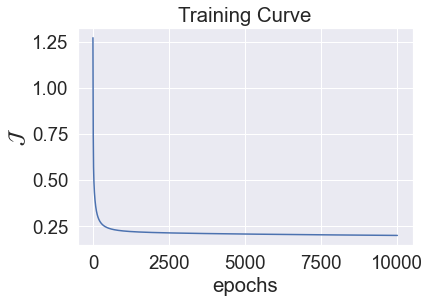

true_pos= 306, false_neg= 69, false_pos= 275, true_neg= 15350
{'accuracy': 97.85, 'precision': 0.5267, 'sensitivity': 0.816, 'specifity': 0.9824, 'recall': 0.816, 'npv': 0.9955, 'f1': 0.6402}


In [176]:
log_reg = MVLogisticRegression()
log_reg.fit(X_train, y_train.astype(int), eta = 1e-1, epochs = 1e4, show_curve = True)
y_hat_log_r = log_reg.predict(X_test)
print(get_metrics(y_test, y_hat_log_r))

In [100]:
# test_imdf_output.shape

In [99]:
# # y_test.shape
# for item in y_test:
# # for item in test_imdf_output:
# # for item in test_data[0]:
# # for item in test_imdf['output']:
#     print(item)

In [ ]:
# print(get_metrics(y_test, y_hat_log_r))
# print(y_test.shape)
# print(y_hat_log_r.shape)

(16000,)
(16000,)


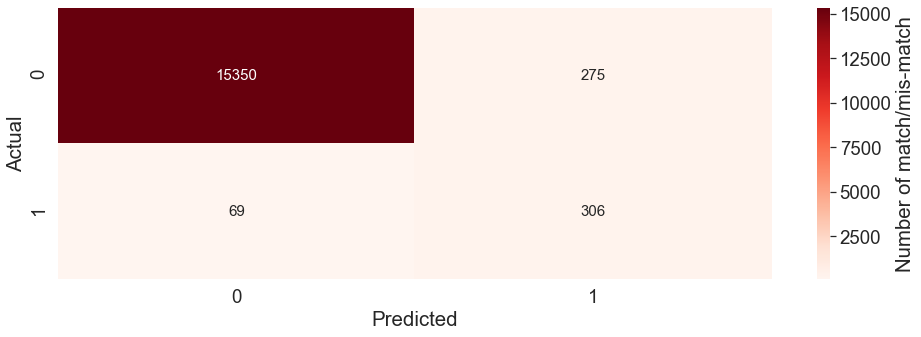

In [177]:
print(y_test.shape)
print(y_hat_log_r.shape)
confusion_matrix = pd.crosstab(y_test.reshape(y_test.shape[0],), y_hat_log_r, rownames=['Actual'], colnames=['Predicted'])

sns.set(font_scale=1.7)
plt.figure(figsize=(16,5))
heatmap = sns.heatmap(confusion_matrix, cmap='Reds', fmt=".0f", annot=True, annot_kws={"size": 15},
                    cbar_kws={'label': 'Number of match/mis-match'})
plt.show()

In [179]:
print(f'Total cost= {(61 * 500 + 465 * 10)}') # With epochs = 1e3
print(f'Total cost= {(69 * 500 + 275 * 10)}') # With epochs = 1e4

Total cost= 35150
Total cost= 37250


## Removing highly correlated columns

In [97]:
# print(imosdf.shape)
# print(test_imdf.shape)

# lcosdf = imosdf.copy(deep=True)
# test_lcosdf = test_imdf.copy(deep=True)

# def find_col_in_sets(sets, item):
#     for i in range(len(sets)):
#         if item in sets[i]:
#             return i
#     return None
    
# osdf_corr = lcosdf.corr()
# high_corr_sets = []
# row, col = osdf_corr.shape
# cols = osdf_corr.columns
# for i in range(1, col):
#     for j in range(i+1, col):
#         if osdf_corr.loc[cols[i], cols[j]] > 0.95:
#             setIndex1 = find_col_in_sets(high_corr_sets, cols[i])
#             setIndex2 = find_col_in_sets(high_corr_sets, cols[j])
# #             print('osdf_corr[', cols[i], ',', cols[j], ']=', osdf_corr.loc[cols[i], cols[j]])
#             if setIndex1 == None and setIndex2 == None:
#                 high_corr_sets.append(set(list([cols[i], cols[j]])))
# #                 print(set(list([cols[i], cols[j]])))
#             elif setIndex1 != None and setIndex2 == None:
#                 high_corr_sets[setIndex1].add(cols[j])
# #                 print(high_corr_sets[setIndex1])
#             elif setIndex1 == None and setIndex2 != None:
#                 high_corr_sets[setIndex2].add(cols[i])
# #                 print(high_corr_sets[setIndex2])
#             elif setIndex1 != None and setIndex2 != None and setIndex1 != setIndex2:
#                 high_corr_sets[setIndex1] = high_corr_sets[setIndex1].union(high_corr_sets[setIndex2])
# #                 print('Pop', high_corr_sets[setIndex1])
#                 high_corr_sets.pop(setIndex2)

# print('high_corr_sets=', high_corr_sets)

# for high_corr_set in high_corr_sets:
#     high_corr_list = list(high_corr_set)
#     max_output_corr = 0
#     max_output_corr_index = 0
#     for i in range(len(high_corr_list)):
#         if osdf_corr.loc[cols[0], cols[i]] > max_output_corr:
#             max_output_corr = osdf_corr.loc[cols[0], cols[i]]
#             max_output_corr_index = i
#     print(max_output_corr_index)
# #     firstItem = high_corr_list[0]
#     for i in range(1, len(high_corr_list)):
#         if i != max_output_corr_index:
#             lcosdf = lcosdf.drop([high_corr_list[i]], axis=1)
#             test_lcosdf = test_lcosdf.drop([high_corr_list[i]], axis=1)
        
# print(lcosdf.shape)
# print(test_lcosdf.shape)

## Removing highly correlated columns - Part 2

In [98]:
# # 0.75 and 0.95
# print(imosdf.shape)
# print(test_imdf.shape)

# lcosdf = imosdf.copy(deep=True)
# test_lcosdf = test_imdf.copy(deep=True)

# osdf_corr = imosdf.corr()
# row, col = osdf_corr.shape
# cols = osdf_corr.columns
# cols_list = list(cols)

# output_corr_dict = dict()
# for i in range(1, col):
#     if abs(osdf_corr.loc[cols[1], cols[i]]) > 0.75:
#         output_corr_dict[cols[i]] = abs(osdf_corr.loc[cols[0], cols[i]])
    
# output_corr_dict = dict(sorted(output_corr_dict.items(), reverse = True, key=lambda item: item[1]))   
# chosen_cols = ['output']
# dict_keys = list(output_corr_dict.keys())
# while len(output_corr_dict) > 0:
#     highest_output_corr = dict_keys[0]
#     dict_keys.pop(0)
#     chosen_cols.append(highest_output_corr)
#     output_corr_dict.pop(highest_output_corr)
#     item_list = list(output_corr_dict.items())
#     for item in item_list:
#         if osdf_corr.loc[highest_output_corr, item[0]] > 0.95:
#             dict_keys.remove(item[0])
#             output_corr_dict.pop(item[0])

# print('Selected columns:')
# for col in chosen_cols:
#     print(col)

# lcosdf = lcosdf[chosen_cols].copy()
# test_lcosdf = test_imdf[chosen_cols].copy()

# print(lcosdf.shape)
# print(test_lcosdf.shape)

In [74]:
# lcosdf['output'] = lcosdf['output'].astype(int)
# test_lcosdf['output'] = test_lcosdf['output'].astype(int)

# imosdf_output = lcosdf['output'].copy(deep=True)
# test_imdf_output = test_lcosdf['output'].copy(deep=True)

# lcosdf = lcosdf.drop(columns=['output'], axis = 1, inplace = False)
# test_lcosdf = test_lcosdf.drop(columns=['output'], axis = 1, inplace = False)

# # train_data = lcosdf.to_numpy()
# # test_data = test_lcosdf.to_numpy()

# X_train = lcosdf.to_numpy()
# y_train = imosdf_output.to_numpy()

# X_test = test_lcosdf.to_numpy()
# y_test = test_imdf_output.to_numpy()

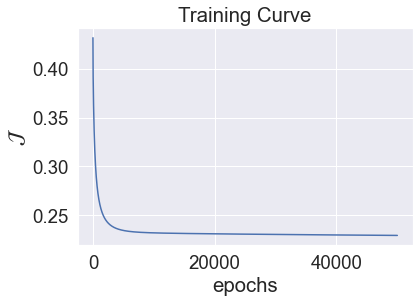

true_pos= 309, false_neg= 66, false_pos= 414, true_neg= 15211
{'accuracy': 97.0, 'precision': 0.4274, 'sensitivity': 0.824, 'specifity': 0.9735, 'recall': 0.824, 'npv': 0.9957, 'f1': 0.5629}


In [76]:
# log_reg = MVLogisticRegression()
# log_reg.fit(X_train, y_train.astype(int), eta = 1e-1, epochs = 5e4, show_curve = True)
# y_hat_log_r = log_reg.predict(X_test)
# print(get_metrics(y_test, y_hat_log_r))

(16000,)
(16000,)


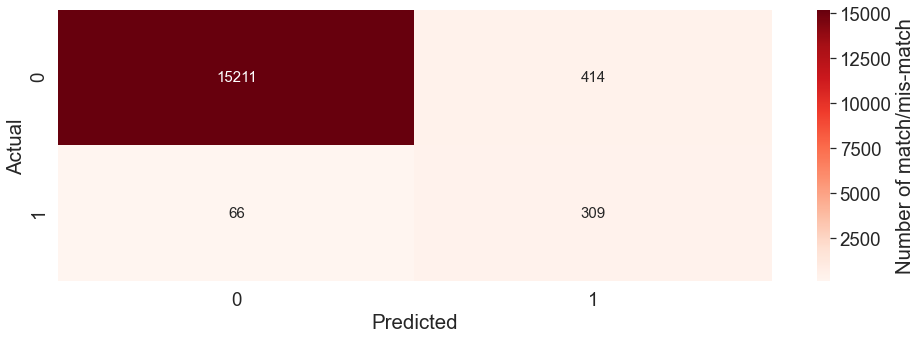

In [77]:
# print(y_test.shape)
# print(y_hat_log_r.shape)
# confusion_matrix = pd.crosstab(y_test.reshape(len(y_test),), y_hat_log_r, rownames=['Actual'], colnames=['Predicted'])

# sns.set(font_scale=1.7)
# plt.figure(figsize=(16,5))
# heatmap = sns.heatmap(confusion_matrix, cmap='Reds', fmt=".0f", annot=True, annot_kws={"size": 15},
#                     cbar_kws={'label': 'Number of match/mis-match'})
# plt.show()

In [78]:
# print(f'Total cost= {(49 * 500 + 455 * 10)}') # With 16 columns and epochs = 1e4
# print(f'Total cost= {(72 * 500 + 375 * 10)}') # With 7 columns and epochs = 1e4
# print(f'Total cost= {(64 * 500 + 430 * 10)}') # With 7 columns and epochs = 1e5
# print(f'Total cost= {(66 * 500 + 414 * 10)}') # With 10 columns and epochs = 1e5

Total cost= 29050
Total cost= 39750
Total cost= 36300
Total cost= 37140


## Fitting a Non-Naive Gaussian Bayese Classifier

In [ ]:
# y_test, y_hat_test = fit_predict(lcosdf, test_lcosdf, gb)

In [ ]:
# confusion_matrix = pd.crosstab(y_test, y_hat_test, rownames=['Actual'], colnames=['Predicted'])

# sns.set(font_scale=1.7)
# plt.figure(figsize=(16,5))
# heatmap = sns.heatmap(confusion_matrix, cmap='Reds', fmt=".0f", annot=True, annot_kws={"size": 15},
#                     cbar_kws={'label': 'Number of match/mis-match'})
# plt.show()

## Fitting a KNN Classifier

In [ ]:
# train_data = lcosdf.to_numpy()
# test_data = test_lcosdf.to_numpy()
# X_train = train_data[:, 1:]
# y_train = train_data[:, :1]
# X_test = test_data[:, 1:]
# y_test = test_data[:, :1]

In [ ]:
# myKnn = KNNClassifier()

# myKnn.fit(X_train, y_train)
# y_hat_knn = myKnn.predict(X_test, 15)
# # knn_accr = get_metrics(y_test, y_hat_knn)
# # knn_accr = np.mean(y_test == y_hat)
# print(get_metrics(y_test, y_hat_knn))

In [ ]:
# print(y_test.shape)
# print(y_hat_knn.shape)
# confusion_matrix = pd.crosstab(y_test.reshape(y_test.shape[0],), y_hat_knn, rownames=['Actual'], colnames=['Predicted'])

# sns.set(font_scale=1.7)
# plt.figure(figsize=(16,5))
# heatmap = sns.heatmap(confusion_matrix, cmap='Reds', fmt=".0f", annot=True, annot_kws={"size": 15},
#                     cbar_kws={'label': 'Number of match/mis-match'})
# plt.show()

In [ ]:
# myLR = LinearRegression()

# myLR.fit(X_train, y_train)
# y_hat_lin_r = myLR.predict(X_test)

# # A round function works like a step function on 0.5.
# y_hat_lin_r = np.around(y_hat_lin_r)
# np.clip(y_hat_lin_r, 0, 1, y_hat_lin_r)
# # lr_accr = get_metrics(y_test, y_hat_lin_r)
# print(get_metrics(y_test, y_hat_lin_r))

In [ ]:
# print(y_test.shape)
# print(y_hat_lin_r.shape)
# confusion_matrix = pd.crosstab(y_test.reshape(16000,), y_hat_lin_r.reshape(16000,), rownames=['Actual'], colnames=['Predicted'])

# sns.set(font_scale=1.7)
# plt.figure(figsize=(16,5))
# heatmap = sns.heatmap(confusion_matrix, cmap='Reds', fmt=".0f", annot=True, annot_kws={"size": 15},
#                     cbar_kws={'label': 'Number of match/mis-match'})
# plt.show()

## Fitting a Linear Regression

## Fitting a KNN Regressor

In [ ]:
# myKnnR = KNNRegressor()

# myKnnR.fit(X_train, y_train)
# y_hat_knn_r = myKnnR.predict(X_test, 15)

# # A round function works like a step function on 0.5.
# y_hat_knn_r = np.around(y_hat_knn_r)
# np.clip(y_hat_knn_r, 0, 1, y_hat_knn_r)

# # knnr_accr = get_metrics(y_test, y_hat_knn_r)
# print(get_metrics(y_test, y_hat_knn_r))

In [ ]:
# print(y_test.shape)
# print(y_hat_knn_r.shape)
# confusion_matrix = pd.crosstab(y_test.reshape(16000,), y_hat_knn_r, rownames=['Actual'], colnames=['Predicted'])

# sns.set(font_scale=1.7)
# plt.figure(figsize=(16,5))
# heatmap = sns.heatmap(confusion_matrix, cmap='Reds', fmt=".0f", annot=True, annot_kws={"size": 15},
#                     cbar_kws={'label': 'Number of match/mis-match'})
# plt.show()

## Fitting a Logistic Regressor

In [ ]:
# log_reg = MVLogisticRegression()
# log_reg.fit(X_train, y_train.astype(int), eta = 1e-1, epochs = 1e4, show_curve = True)
# y_hat_log_r = log_reg.predict(X_test)
# print(get_metrics(y_test, y_hat_log_r))

In [ ]:
# print(y_test.shape)
# print(y_hat_log_r.shape)
# confusion_matrix = pd.crosstab(y_test.reshape(16000,), y_hat_log_r, rownames=['Actual'], colnames=['Predicted'])

# sns.set(font_scale=1.7)
# plt.figure(figsize=(16,5))
# heatmap = sns.heatmap(confusion_matrix, cmap='Reds', fmt=".0f", annot=True, annot_kws={"size": 15},
#                     cbar_kws={'label': 'Number of match/mis-match'})
# plt.show()

## Check runnnig average, etc for imputation.